Best combination: max_depth=3, min_samples_split=2, min_samples_leaf=1, ccp_alpha=0.0
Corresponding Mean Squared Error: 4673.048875062962
Corresponding R-squared: 0.47691691811677206
        Feature  Importance
5     project21    0.666741
10     actual19    0.120307
6      actual20    0.086164
13     fumble19    0.050398
4      points20    0.043840
14  pass_latent    0.032550
0            TE    0.000000
15  rush_latent    0.000000
12         pt19    0.000000
11    recepts19    0.000000
8      fumble20    0.000000
9      points19    0.000000
1            WR    0.000000
7     recepts20    0.000000
3            QB    0.000000
2            RB    0.000000
16   rec_latent    0.000000


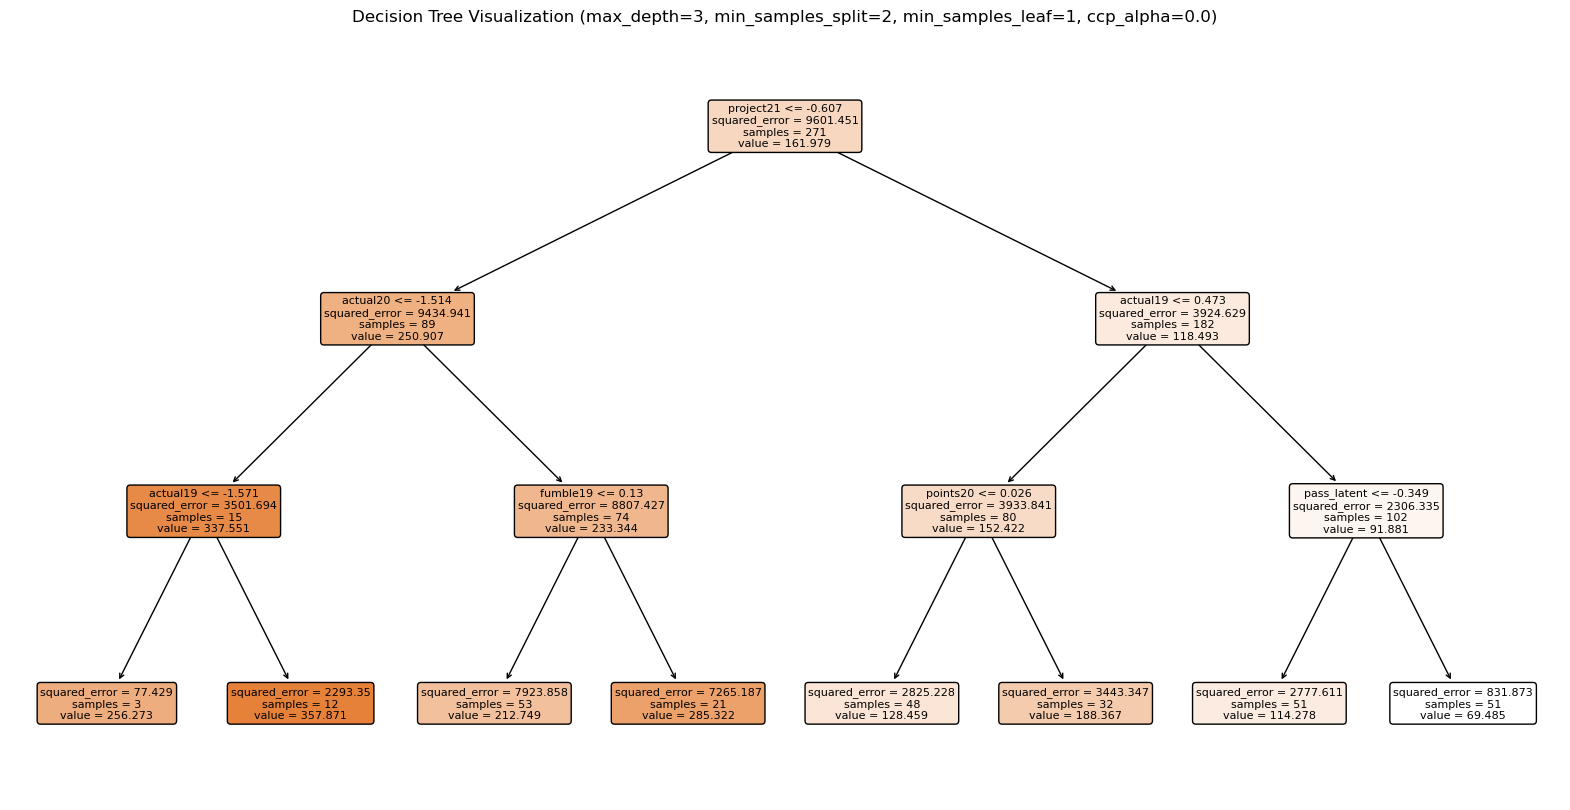

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

data = pd.read_csv('/Users/nick/Desktop/imputed_data.csv')

# Select subset of independent variables
pass_cols = ['passyds20','passtd20','passint20','passyds19','passtd19','passint19']  
rush_cols = ['rushyds20','rushyds19','rushtd20','rush1st20', 'rushtd19','rush1st19']
rec_cols = ['recyds20', 'rectd20', 'rec1st20', 'recyds19', 'rectd19', 'rec1st19']
subset1_data = data[pass_cols]
subset2_data = data[rush_cols]
subset3_data = data[rec_cols]

# Data preprocessing
scaler = StandardScaler()
subset1_scaled = scaler.fit_transform(subset1_data)
subset2_scaled = scaler.fit_transform(subset2_data)
subset3_scaled = scaler.fit_transform(subset3_data)

# PCA on the subset
num_components = 3 
pca = PCA(n_components=num_components)
subset1_pca = pca.fit_transform(subset1_scaled)
subset2_pca = pca.fit_transform(subset2_scaled)
subset3_pca = pca.fit_transform(subset3_scaled)

data['pass_latent'] = subset1_pca[:, 0]
data['rush_latent'] = subset2_pca[:, 0]
data['rec_latent'] = subset3_pca[:, 0]

import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor, export_graphviz, plot_tree
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import warnings

df = pd.read_csv('/Users/nick/Desktop/imputed_data.csv')

df['pass_latent'] = subset1_pca[:, 0]
df['rush_latent'] = subset2_pca[:, 0]
df['rec_latent'] = subset3_pca[:, 0]

bad_cols = ['gp_21', 'points21', 'projected22', 'actual21', 'passyd_21', 'passtds21', 'int21', 'runyds21', 'runtds21', 'run1st21', 'rec21', 'recyds21', 'rectds21', 'pass1st21', 'returnyds21', 'returntds21', 'twopoint21', 'fumble21']
pass_cols = ['passyds20','passtd20','passint20','passyds19','passtd19','passint19']  
rush_cols = ['rushyds20','rushyds19','rushtd20','rush1st20', 'rushtd19','rush1st19']
rec_cols = ['recyds20', 'rectd20', 'rec1st20', 'recyds19', 'rectd19', 'rec1st19']

X = df.drop(columns = bad_cols + pass_cols + rush_cols + rec_cols)
y = df['points21']
kf = KFold(n_splits=6, shuffle=True)

# lists for max_depth, min_samples_split, min_samples_leaf, and ccp_alpha values iteration
max_depth_values = [3]
min_samples_split_values = [2, 5, 7]
min_samples_leaf_values = [1, 2, 4, 8]
ccp_alpha_values = [0.0, 0.01]

# for storing results for each comb of hyperparameters
results = {}

# for storing models for each comb of hyperparameters
models_mapping = {}

#i get a lot of warnings when I run the code so this hides them
warnings.filterwarnings("ignore", category=UserWarning)

# iterate through different max_depth, min_samples_split, min_samples_leaf, and ccp_alpha values
for max_depth in max_depth_values:
    for min_samples_split in min_samples_split_values:
        for min_samples_leaf in min_samples_leaf_values:
            for ccp_alpha in ccp_alpha_values:
                mse_scores = []
                r_squared_scores = []

                # perform k-fold
                for train_index, test_index in kf.split(X):
                    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

                    # standardize train and test
                    scaler = StandardScaler()
                    X_train_scaled = scaler.fit_transform(X_train)
                    X_test_scaled = scaler.transform(X_test)

                    # decision tree regression model with hyperparameters and ccp pruning
                    dt_model = DecisionTreeRegressor(
                        max_depth=max_depth,
                        min_samples_split=min_samples_split,
                        min_samples_leaf=min_samples_leaf,
                        ccp_alpha=ccp_alpha,
                        random_state=42
                    )

                    # fit the model on training data
                    dt_model.fit(X_train_scaled, y_train)

                    # make predictions on the test set
                    y_pred = dt_model.predict(X_test_scaled)

                    # eval the model
                    mse = mean_squared_error(y_test, y_pred)
                    mse_scores.append(mse)

                    # calc R-squared
                    r_squared = r2_score(y_test, y_pred)
                    r_squared_scores.append(r_squared)

                # calc avg MSE and R-squared across folds
                avg_mse = np.mean(mse_scores)
                avg_r_squared = np.mean(r_squared_scores)

                # store the results for this combination of hyperparameters
                results[(max_depth, min_samples_split, min_samples_leaf, ccp_alpha)] = (avg_mse, avg_r_squared)

                # store the model for this combination of hyperparameters
                models_mapping[(max_depth, min_samples_split, min_samples_leaf, ccp_alpha)] = dt_model

# combination of hyperparameters that maximizes R-squared
best_combination = max(results, key=lambda x: results[x][1])
best_mse, best_r_squared = results[best_combination]

# print the best combination and its corresponding MSE and R-squared
print(f'Best combination: max_depth={best_combination[0]}, min_samples_split={best_combination[1]}, min_samples_leaf={best_combination[2]}, ccp_alpha={best_combination[3]}')
print(f'Corresponding Mean Squared Error: {best_mse}')
print(f'Corresponding R-squared: {best_r_squared}')

# ccess the best model using the best combination of hyperparameters
best_model = models_mapping[best_combination]

# feature importances
feature_importances = best_model.feature_importances_

# df to display feature importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# sort df by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# display the feature importances
print(feature_importance_df)

# show the decision tree with the best combination of hyperparameters
plt.figure(figsize=(20, 10))
plot_tree(best_model, filled=True, feature_names=X.columns.tolist(), rounded=True, fontsize=8)
plt.title(f'Decision Tree Visualization (max_depth={best_combination[0]}, min_samples_split={best_combination[1]}, min_samples_leaf={best_combination[2]}, ccp_alpha={best_combination[3]})')
plt.show()